<a href="https://colab.research.google.com/github/alefefreire/MLtraining/blob/master/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Dataset info

Citation Request:
  This dataset is public available for research. The details are described in [Moro et al., 2011]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

1. Title: Bank Marketing

2. Sources
   Created by: Paulo Cortez (Univ. Minho) and Sérgio Moro (ISCTE-IUL) @ 2012
   
3. Past Usage:

  The full dataset was described and analyzed in:

  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, 
  Portugal, October, 2011. EUROSIS.

4. Relevant Information:

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

   There are two datasets: 
      1) bank-full.csv with all examples, ordered by date (from May 2008 to November 2010).
      2) bank.csv with 10% of the examples (4521), randomly selected from bank-full.csv.
   The smallest dataset is provided to test more computationally demanding machine learning algorithms (e.g. SVM).

   The classification goal is to predict if the client will subscribe a term deposit (variable y).

5. Number of Instances: 45211 for bank-full.csv (4521 for bank.csv)

6. Number of Attributes: 16 + output attribute.

7. Attribute information:

   For more information, read [Moro et al., 2011].

   Input variables:
   # bank client data:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")

   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric) 
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   
   # related with the last contact of the current campaign:
   
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

8. Missing Attribute Values: None


In [0]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
from scipy.stats import mode, gaussian_kde
from scipy.optimize import minimize, shgo
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=2)
from sklearn.model_selection import GridSearchCV
path=r'/content/drive/My Drive/Data/'

df=pd.read_csv(path+'bank-full.csv',sep=';')

# Utils

In [0]:
def rrmse(y_true,y_pred):
    return np.sqrt(mse(y_true,y_pred))/np.mean(y_true)

def split_df(data,ids,val_size,id_col,shuffle=True):
    if shuffle: rn.shuffle(camps)

    length = len(ids)

    split = int(val_size * length)

    idx_val = ids[-split:]
    idx_tr = ids[:-split]
    
    return data[data[id_col].isin(idx_tr)],data[data[id_col].isin(idx_val)]

def cross_valid(model,x,folds,metric,verbose=True):
    """ 
    This function does cross validation for general regressors. 
        model: Sklearn model or customized model with fit and predict methods;
        x : Data as a numpy matrix containg with ***the last column as target***;
        folds: Number of folds;
        metrics : 'mae': mse,'rmse','rrmse'
        verbose: Flag to print report over iterations;
        
    returns: List with scores over the folders
    """    

    score=[]
    

    kf = KFold(folds,shuffle=False,random_state=0) 


    i=0
    for train_index, test_index in kf.split(x):

        xtrain = x[train_index,:]
        xtest = x[test_index,:]

        model.fit(xtrain[:,:-1],xtrain[:,-1])

        ypred = model.predict(xtest[:,:-1])

        ytrue= xtest[:,-1] 
          
              
        if metric == 'mae':
            score.append(mae(ytrue,ypred))
        elif metric == 'mse':
            score.append(mse(ytrue,ypred))
        elif metric == 'rrmse':
            score.append(rrmse(ytrue,ypred))

        else:
            score.append(rmse(xtest[:,-1],ypred))

        if verbose:
            print('-'*30)
            print(f'\nFold {i+1} out of {folds}')
            print(f'{metric}: {score[i]}')

        i+=1

    if verbose:
        print(f'\n Overall Score:')
        print(f'{metric}:    Mean: {np.mean(score)}   Std: {np.std(score)}')


    return score
def cross_valid_key(model,x,key,preds,target,metric,verbose=True):
    """ 
    This function does cross validation for general regressors. 
        model: Sklearn model or customized model with fit and predict methods;
        x : Data as a numpy matrix containg with ***the last column as target***;
        key: Column name containing keys for spliting the folds;
        metrics : 'mae': mse,'rmse','rrmse'
        verbose: Flag to print report over iterations;
        
    returns: List with scores over the folders
    """    

    score=[]
    
    keys = x[key].unique().tolist()
 


    for idx, item in enumerate([1,2,3,4,5]):

        xtrain,xtest = split_camp(x,keys,0.2)
        
        model.fit(xtrain[feat],xtrain[target])

        ypred = model.predict(xtest[feat])
        
        ytrue= xtest[target].values 
          
        if metric == 'mae':
            score.append(mae(ytrue,ypred))
        elif metric == 'mse':
            score.append(mse(ytrue,ypred))
        elif metric == 'rrmse':
            score.append(rrmse(ytrue,ypred))

        else:
            score.append(rmse(xtest[target].tolist(),ypred))

        if verbose:
            print('-'*30)
            print(f'\nFold {idx} out of 5')
            print(f'Key {item}')
            print(f'{metric}: {score[idx]}')

 

    if verbose:
        print(f'\n Overall Score:')
        print(f'{metric}:    Mean: {np.mean(score)}   Std: {np.std(score)}')


    return score

def kde(array, cut_down=True, bw_method='scott'):
    if cut_down:
        bins, counts = np.unique(array, return_counts=True)
        f_mean = counts.mean()
        f_above_mean = bins[counts > f_mean]
        bounds = [f_above_mean.min(), f_above_mean.max()]
        array = array[np.bitwise_and(bounds[0] < array, array < bounds[1])]
    return gaussian_kde(array, bw_method=bw_method)

def mode_estimation(array, cut_down=True, bw_method='scott'):
    kernel = kde(array, cut_down=cut_down, bw_method=bw_method)
    bounds = np.array([[array.min(), array.max()]])
    results = shgo(lambda x: -kernel(x)[0], bounds=bounds, n=100*len(array))
    return results.x[0]

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):    
        xticks = np.arange(0,lags)
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

# Adpated from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/        
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    var_n= data.columns.tolist()
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))                    
        names += [(var_n[j]+'(t-%d)' % ( i)) for j in range(n_vars)]
 
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_n[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_n[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
 
    return agg
 
 
def dataTimeSeries(timesteps,df,predictors,target,dropnan,out=2,dropVars=True):
    """ 
    This function transforms a dataframe in a timeseries for surpervised learning.
        timesteps: Number of delays (i.e: timesteps =2 (t),(t-1),(t-2));
        df: Dataframe;
        predictors: List of columns in dataframe as features for the ML algorithm;
        target: Target of the supervised learning;
        dropnan: Flag to drop the NaN values after transforming the 
        out: Number of steps to forecast (i.e: out = 2 (t),(t+1));
        dropVars= Leave only the Target of the last timestep on the resulting dataframe;
    """    
    
    series = series_to_supervised(df[predictors+[target]].copy(),timesteps,out,dropnan=dropnan)
 
    if dropnan==False:
        series.replace(pd.np.nan,0,inplace=True)
    
    # Dropping other variables:
    if dropVars:
        index = list(np.arange(series.shape[1]-2,
                               series.shape[1]-len(predictors)-2,
                               -1))
 
        labels = [item  for idx,item in enumerate(series.columns) 
                  if idx in index]
 
        #print("Eliminando variáveis: {}".format(labels))
        series.drop(labels,axis=1,inplace=True)  
 
    return series

class Cross_valid_clf():
  """ 
    This class does cross validation for general classifiers. 
        model: Sklearn model or customized model with fit and predict methods;
        X: array with values for features
        y:array with values for target
        folds: Number of folds;
        metrics : accuracy,f1score, precision,recall,fbeta score;
        stratified: Use stratified Kfold to keep the ratio of classes in all folds;
        beta: Beta parameter for fbeta score metric;
        verbose: Flag to print report over iterations;
        
    returns: List with scores over the folders
  """            
  def __init__(self, X, y,n_splits,stratified=True):
    self.n_splits = n_splits
    self.X = X
    self.y = y
        
    if stratified:
        self.kf=StratifiedKFold(self.n_splits,shuffle=False,random_state=0)
        self.kf.get_n_splits(self.X)
    else:
        self.kf=KFold(self.n_splits,shuffle=False,random_state=0)
        self.kf.get_n_splits(self.X)

  #score method
  def score(self, clf,verbose=True):
        score = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            clf.fit(self.X[tr],self.y[tr])
            score.append(clf.score(self.X[te],self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'Accuracy_score: {score[i]}')
            i+=1
        if verbose:
            print(f'\n Overall Score:')
            print(f'Accuracy_score Mean: {np.mean(score)}   Std: {np.std(score)}')
        return np.mean(score)
    #f1score method
  def f1score(self, clf,verbose=True):
        f1score = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            clf.fit(self.X[tr],self.y[tr])
            y_pred=clf.predict(self.X[te])
            f1score.append(f1_score(y_pred,self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'f1_score: {f1score[i]}')
            i+=1
        if verbose:
            print(f'\n Overall f1score:')
            print(f'f1score Mean: {np.mean(f1score)}   Std: {np.std(f1score)}')
        return np.mean(f1score)
    #precision score
  def precisionscore(self, clf,verbose=True):
        prec_score = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            clf.fit(self.X[tr],self.y[tr])
            y_pred=clf.predict(self.X[te])
            prec_score.append(precision_score(y_pred,self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'Precision_score: {prec_score[i]}')
            i+=1
        if verbose:
            print(f'\n Overall Score:')
            print(f'Precision_score Mean: {np.mean(prec_score)}   Std: {np.std(prec_score)}')
        return np.mean(prec_score)
    #Recall score      
  def recallscore(self, clf,verbose=True):
        rec_score = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            clf.fit(self.X[tr],self.y[tr])
            y_pred=clf.predict(y_pred,self.X[te])
            rec_score.append(recall_score(self.X[te],self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'Recall_score: {rec_score[i]}')
            i+=1
        if verbose:
            print(f'\n Overall Score:')
            print(f'Recall_score Mean: {np.mean(rec_score)}   Std: {np.std(rec_score)}')
        return np.mean(rec_score)
    #fbeta score
  def fbetascore(self, clf,verbose=True,beta=0.6):
        fbetascore = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            clf.fit(self.X[tr],self.y[tr])
            y_pred=clf.predict(self.X[te])
            fbetascore.append(fbeta_score(y_pred,self.y[te],beta))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'fbeta_score: {fbetascore[i]}')
            i+=1
        if verbose:
            print(f'\n Overall Score:')
            print(f'fbeta_score Mean: {np.mean(fbetascore)}   Std: {np.std(fbetascore)}')
        return np.mean(fbetascore)

class Cross_valid_reg():
  """ 
    This class does cross validation for general regressors. 
        model: Sklearn model or customized model with fit and predict methods;
        x : features;
        y: target
        folds: Number of folds;
        metrics : RMSE =root mean squared error; MAE= mean absolute error
        stratified: Use stratified Kfold to keep the ratio of classes in all folds;
        verbose: Flag to print report over iterations;
        
    returns: List with scores over the folders
  """    
  def __init__(self, X, y,n_splits,stratified=True):
    self.n_splits = n_splits
    self.X = X
    self.y = y
        
    if stratified:
        self.kf=StratifiedKFold(self.n_splits,shuffle=False,random_state=0)
        self.kf.get_n_splits(self.X)
    else:
        self.kf=KFold(self.n_splits,shuffle=False,random_state=0)
        self.kf.get_n_splits(self.X)

  #score method
  def rmse(self, reg,verbose=True,overall=True):
    #rmse
        rmse = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            reg.fit(self.X[tr],self.y[tr])
            y_pred=reg.predict(self.X[te])
            rmse.append(np.sqrt(mean_squared_error(y_pred,self.y[te])))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'RMSE: {rmse[i]}')
            i+=1
        if verbose:
            print(f'\n Overall RMSE:')
            print(f'RMSE Mean: {np.mean(rmse)}   Std: {np.std(rmse)}')
        if overall:
            return np.mean(rmse)
        else:
            return rmse
    #mae
  def mae(self, reg,verbose=True,overall=True):
        mae = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            reg.fit(self.X[tr],self.y[tr])
            y_pred=reg.predict(self.X[te])
            mae.append(mean_absolute_error(y_pred,self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'MAE: {mae[i]}')
            i+=1
        if verbose:
            print(f'\n Overall MAE:')
            print(f'MAE Mean: {np.mean(mae)}   Std: {np.std(mae)}')
        if overall:
            return np.mean(mae)
        else:
            return mae
  def r2(self, reg,verbose=True,overall=True):
        r2 = []
        i=0
        for tr, te in self.kf.split(self.X,self.y):
            reg.fit(self.X[tr],self.y[tr])
            y_pred=reg.predict(self.X[te])
            mae.append(r2_score(y_pred,self.y[te]))
            if verbose:
                print('-'*30)
                print(f'\nFold {i+1} out of {self.n_splits}')
                print(f'R2: {r2[i]}')
            i+=1
        if verbose:
            print(f'\n Overall R2:')
            print(f'R2 Mean: {np.mean(r2)}   Std: {np.std(r2)}')
        if overall:
            return np.mean(r2)
        else:
            return r2  
    #precision score

def feature_importance_plot(algorithm,X_train,y_train,of_type):
    """This function does the feature importance for any classifiers or regressors.
    Parameters
    ----------------
    algorithm: Algorithm which one wants to importance the relevant features
    X_train: axis x of the train dataframe
    y_train: axis y of the target dataframe
    of_type: 'coef' or 'feat', depending on the algorithm.
    Return
    -----------------
    Plot with feature importances
    """
    if of_type == "coef":
        algorithm.fit(X_train,y_train)
        coef = pd.DataFrame(algorithm.coef_.ravel())
        coef["coef"] = X_train.columns
        plt.figure(figsize=(14,4))
        ax1 = sns.barplot(coef["coef"],coef[0],palette="jet_r",
                          linewidth=2,edgecolor="k"*coef["coef"].nunique())
        #ax1.set_facecolor("lightgrey")
        ax1.axhline(0,color="k",linewidth=2)
        plt.ylabel("coefficients")
        plt.xlabel("features")
        plt.xticks(rotation='vertical')
        plt.title('FEATURE IMPORTANCES')
    
    elif of_type == "feat":
        algorithm.fit(X_train,y_train)
        coef = pd.DataFrame(algorithm.feature_importances_)
        coef["feat"] = X_train.columns
        plt.figure(figsize=(14,4))
        ax2 = sns.barplot(coef["feat"],coef[0],palette="jet_r",
                          linewidth=2,edgecolor="k"*coef["feat"].nunique())
        #ax2.set_facecolor("lightgrey")
        ax2.axhline(0,color="k",linewidth=2)
        plt.ylabel("coefficients")
        plt.xlabel("features")
        plt.xticks(rotation='vertical')
        plt.title('FEATURE IMPORTANCES')
def algorithm_grid_search_cv(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

# Preparing Data

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Exploratory Data Analysis



## Bar Plots

In [0]:
#taking the categorical columns
categorical=df.select_dtypes(include=['object']).columns.tolist()
del categorical[-1]

In [0]:
def percentage_frauds_per_categorical(categ,df):
  categ_yes=[]
  categ_no=[]
  for idx, member in enumerate(df[categ].unique().tolist()):
    yes=df.loc[df[categ]==member][df.y=='yes'].shape[0]
    no=df.loc[df[categ]==member][df.y=='no'].shape[0]
    length=yes+no
    categ_yes.append(yes/length*100)
    categ_no.append(no/length*100)

  return categ_yes,categ_no

In [0]:
import plotly.graph_objects as go

def plot_percentage_bar(categ,df):
  yes,no=percentage_frauds_per_categorical(categ,df)

  fig = go.Figure(data=[
    go.Bar(name='yes', x=df[categ].unique().tolist() , y=yes),
    go.Bar(name='no', x=df[categ].unique().tolist(), y=no,)
  ])
  # Change the bar mode
  fig.update_layout(barmode='stack',title='Percentage of (no) fraud per '+ categ+ ' status')
  

  return fig.show()

In [11]:
for member in categorical:
  plot_percentage_bar(member,df)

Insigths;

- The number of frauds is higher for: 

job : retired, unemployed and student

marital: single

education: tertiary and unknow

default: no

housing: no

loan: no

contact: cellular and telephone

month: october, december, march and september

poutcome: success

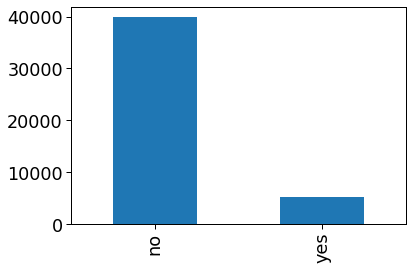

In [12]:
pd.value_counts(df['y']).plot.bar()

We can see that dataset is completely imbalanced!

In [0]:
#dataframe with numerical values only
df_numerical=df[['age','balance','duration']]

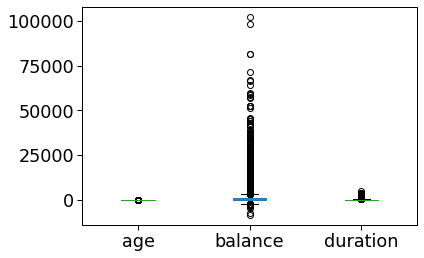

In [41]:
#Plotting the box plots of those numerical columns. Let us verify is there is some outliers (It is important for preprocessing data)

df_numerical.plot(kind='box')

The most indicated standizer in the presenco of outliers is the RobustScaler()

# Featuring Engineering

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [0]:
data=df.copy()

In [0]:
#fist converting yes:1 and no:0
data['y'].replace({'yes':1,'no':0},inplace=True)


In [0]:
#converting categorical to dummies variables
data=pd.get_dummies(data)

In [31]:
data.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate input features and target
y = data.y
X = data.drop('y', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

#Machine Learning

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pip=Pipeline([('std',RobustScaler()),('clf',None)])

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier 

metric={'LR':None,'SVC':None,'XGB':None,'DT':None,'LGBM':None}
clfs={'LR':LogisticRegression(),'SVC':SVC(),'XGB':XGBClassifier(),'DT':DecisionTreeClassifier(),'LGBM':LGBMClassifier()}

In [79]:
#Doing CV for all clasiifiers in the above
cv=Cross_valid_clf(X_train,y_train,n_splits=5)

for key,item in clfs.items():
    print("-"*100)
    print(str(item))
    metric[key]=cv.f1score(pip)

----------------------------------------------------------------------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
------------------------------

Fold 1 out of 5
f1_score: 0.5193970842599456
------------------------------

Fold 2 out of 5
f1_score: 0.9805082654823587
------------------------------

Fold 3 out of 5
f1_score: 0.9770228130641719
------------------------------

Fold 4 out of 5
f1_score: 0.9804147465437788
------------------------------

Fold 5 out of 5
f1_score: 0.9805984873396909

 Overall f1score:
f1score Mean: 0.8875882793379892   Std: 0.1841005527353543
----------------------------------------------------------------------------------------------------
SVC(C=1.0

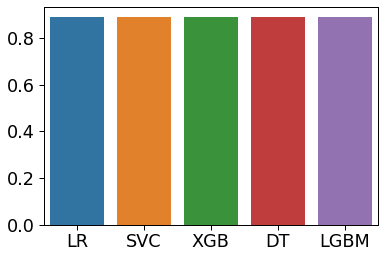

In [80]:
sns.barplot(list(metric.keys()), list(metric.values()))